## Minimal working example:

2025-03-10 13:52:48.291023: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 13:52:48.294155: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 13:52:48.303859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741632768.319691 2497667 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741632768.324400 2497667 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 13:52:48.340927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

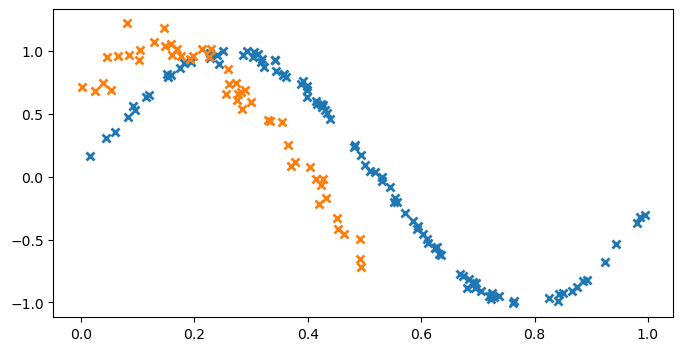

In [1]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


plt.rcParams["figure.figsize"] = (12, 6)
np.random.seed(123)

# make a dataset with two outputs, correlated, heavy-tail noise. One has more noise than the other.
X1 = np.random.rand(100, 1)  # Observed locations for first output
X2 = np.random.rand(50, 1) * 0.5  # Observed locations for second output

Y1 = np.sin(6 * X1) + np.random.randn(*X1.shape) * 0.03
Y2 = np.sin(6 * X2 + 0.7) + np.random.randn(*X2.shape) * 0.1

plt.figure(figsize=(8, 4))
plt.plot(X1, Y1, "x", mew=2)
_ = plt.plot(X2, Y2, "x", mew=2)

## VGP:

In [3]:
# Augment the input with ones or zeros to indicate the required output dimension
X_augmented = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2)))))

# Augment the Y data with ones or zeros that specify a likelihood from the list of likelihoods
Y_augmented = np.vstack((np.hstack((Y1, np.zeros_like(Y1))), np.hstack((Y2, np.ones_like(Y2)))))

print(X_augmented.shape, Y_augmented.shape)


output_dim = 2  # Number of outputs
rank = 1  # Rank of W

# Base kernel
k = gpflow.kernels.Matern32(active_dims=[0])

# Coregion kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])

kern = k * coreg
print(kern)


# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpflow.likelihoods.SwitchedLikelihood(
    [gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian()]
)

# now build the GP model as normal
m = gpflow.models.VGP((X_augmented, Y_augmented), kernel=kern, likelihood=lik)

# fit the covariance function parameters
maxiter = 10000
gpflow.optimizers.Scipy().minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=maxiter),
    method="L-BFGS-B",
)

(150, 2) (150, 2)


2025-03-10 13:52:06.630190: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -225.66187780880978
        x: [-7.926e-01  2.212e+00 ... -7.389e+00 -4.835e+00]
      nit: 1307
      jac: [-1.838e-02 -1.617e-02 ...  4.585e-03 -9.686e-04]
     nfev: 1430
     njev: 1430
 hess_inv: <11483x11483 LbfgsInvHessProduct with dtype=float64>

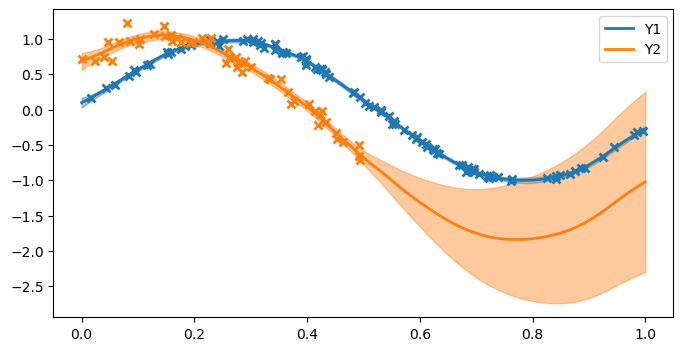

In [4]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )


def plot(m):
    plt.figure(figsize=(8, 4))
    Xtest = np.linspace(0, 1, 100)[:, None]
    (line,) = plt.plot(X1, Y1, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.zeros_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y1")

    (line,) = plt.plot(X2, Y2, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.ones_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y2")

    plt.legend()


plot(m)

## SVGP:

In [2]:
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.ci_utils import reduce_in_tests
from gpflow.utilities import print_summary

# Generate toy data
np.random.seed(42)

N=100

# Augment input with a column indicating the output dimension
X_augmented = np.vstack((
    np.hstack((X1, np.zeros_like(X1))), 
    np.hstack((X2, np.ones_like(X2)))
)).astype(np.float64)

# Augment output with a column indicating the likelihood index
Y_augmented = np.vstack((
    np.hstack((Y1, np.zeros_like(Y1))), 
    np.hstack((Y2, np.ones_like(Y2)))
)).astype(np.float64)

print("Shapes:", X_augmented.shape, Y_augmented.shape)

# Define output dimension
output_dim = 2  # Number of outputs
rank = 1  # Rank of the coregion kernel

# Define base kernel
k = gpflow.kernels.Matern32(active_dims=[0])

# Define coregion kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])

# Combined kernel
kern = k * coreg
print("Kernel:", kern)

# Define likelihood
likelihood = gpflow.likelihoods.SwitchedLikelihood(
    [gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian()]
)

# Define inducing points (subset of training data)
M = 20  # Number of inducing points
Z_init = X_augmented[np.random.choice(len(X_augmented), M, replace=False)]  # Random subset

# Define the sparse variational GP model
m = gpflow.models.SVGP(
    kernel=kern, 
    likelihood=likelihood, 
    inducing_variable=Z_init, 
    num_latent_gps=1
)

# Convert data to TensorFlow tensors
X_augmented_tf = tf.convert_to_tensor(X_augmented)
Y_augmented_tf = tf.convert_to_tensor(Y_augmented)

# Define an optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
epochs = 500
batch_size = 2
dataset = tf.data.Dataset.from_tensor_slices((X_augmented_tf, Y_augmented_tf)).shuffle(len(X_augmented)).batch(batch_size)

for epoch in range(epochs):
    for X_batch, Y_batch in dataset:
        with tf.GradientTape() as tape:
            loss = m.training_loss((X_batch, Y_batch))
        grads = tape.gradient(loss, m.trainable_variables)
        optimizer.apply_gradients(zip(grads, m.trainable_variables))
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

print_summary(m)


Shapes: (150, 2) (150, 2)
Kernel: <gpflow.kernels.base.Product object at 0x7fdac2027b30>


2025-03-10 13:52:52.406136: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-03-10 13:52:52.855475: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0, Loss: 80.6117974301496


2025-03-10 13:52:53.268590: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-10 13:52:53.822202: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-10 13:52:54.936228: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-10 13:52:57.150693: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-10 13:53:01.579382: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 50, Loss: 31.456059898976353


2025-03-10 13:53:10.504282: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 100, Loss: 0.3776662878294683


2025-03-10 13:53:28.290497: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 150, Loss: -24.697096717530542
Epoch 200, Loss: -36.71786257023525
Epoch 250, Loss: -35.32807520625456


2025-03-10 13:54:03.947145: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 300, Loss: -37.72458149429493
Epoch 350, Loss: -40.55071566173369
Epoch 400, Loss: -31.64619105005957
Epoch 450, Loss: -44.080848828437226
╒═════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                    │ class     │ transform        │ prior   │ trainable   │ shape       │ dtype   │ value                                                │
╞═════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════════════════════════════════════════╡
│ SVGP.kernel.kernels[0].variance         │ Parameter │ Softplus         │         │ True        │ ()          │ float64 │ 0.5549733836325106                                   │
├─────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼─────────────────────

(100, 1) (100, 1)


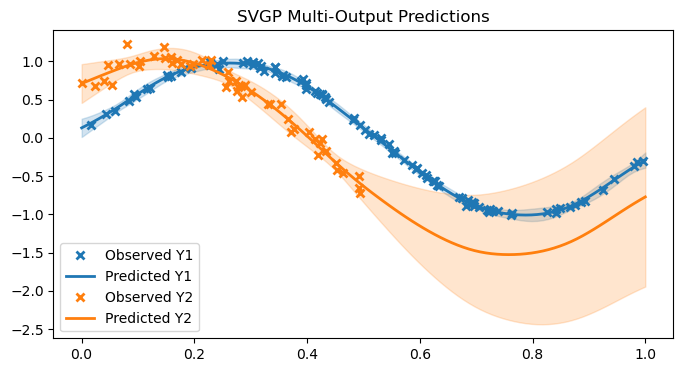

In [3]:
import matplotlib.pyplot as plt

def plot_gp(x, mu, var, color, label):
    """Plots the mean and 2-sigma confidence interval of a GP."""
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.2,
    )

def plot(m, X1, Y1, X2, Y2):
    """Plots the predictions of an SVGP model for multiple outputs."""
    plt.figure(figsize=(8, 4))
    Xtest = np.linspace(0, 1, 100)[:, None]  # Test inputs

    # Convert to TensorFlow tensors
    Xtest_1 = np.hstack((Xtest, np.zeros_like(Xtest)))  # For Y1
    Xtest_2 = np.hstack((Xtest, np.ones_like(Xtest)))   # For Y2

    # Predictions for Y1
    mu1, var1 = m.predict_f(tf.convert_to_tensor(Xtest_1, dtype=tf.float64))
    print(mu1.shape, var1.shape)
    (line1,) = plt.plot(X1, Y1, "x", mew=2, label="Observed Y1")
    plot_gp(Xtest, mu1, var1, line1.get_color(), "Predicted Y1")

    # Predictions for Y2
    mu2, var2 = m.predict_f(tf.convert_to_tensor(Xtest_2, dtype=tf.float64))
    (line2,) = plt.plot(X2, Y2, "x", mew=2, label="Observed Y2")
    plot_gp(Xtest, mu2, var2, line2.get_color(), "Predicted Y2")

    plt.legend()
    plt.title("SVGP Multi-Output Predictions")
    plt.show()

# Call the function with training data
plot(m, X1, Y1, X2, Y2)
